# Processing Big Data - Data profiling

© Explore Data Science Academy

## Honour Code
I {**Daluxolo**, **Mbatha**}, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).
    Non-compliance with the honour code constitutes a material breach of contract.

## Context

Having completed the first step - data ingestion, the data now needs to be thoroughly prepared so that it is readable, reliable and robust. As the Data Engineer in the team, this will be your responsibility. The Data Scientists are looking to you to clean this data so that model development and deployment become seamless when the data is used in a production environment. Having completed your Data Engineering course recently, your manager Gnissecorp Atadgid, asks you to create data summaries and perform checks using the six dimensions of data quality.

<div align="center" style="width: 600px; font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://github.com/Explore-AI/Pictures/raw/master/data_engineering/transform/predict/DataQuality.jpg"
     alt="Data Quality"
     style="float: center; padding-bottom=0.5em"
     width=100%/>
     <p><em>Figure 1. Six dimensions of data quality</em></p>
</div>

## Import libraries
Below we import the libraries required to complete this section of the predict.

In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import Window
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *

Remember that we need a `SparkContext` and `SparkSession` to interface with Spark.
We will mostly be using the `SparkContext` to interact with RDDs 
and the `SparkSession` to interface with Python objects.

> ℹ️ **Instructions** ℹ️
>
>Initialise a new **Spark Context** and **Session** that you will use to interface with Spark.

In [30]:
#TODO: Write your code here.
spark = SparkSession.builder\
  .config("spark.sql.shuffle.partitions", 5)\
  .config("spark.executor.memory", "8g")\
  .master("local[*]")\
  .appName("Predict")\
  .getOrCreate()

## Parquet files
In the previous section of the predict, you generated parquet files to your local directory. You will be making use of these files to continue with this section of the predict. Please make sure that your parquet files are specifically for the year **1962**. Any other year used outside of **1962** will produce incorrect answers and have a negative impact on your overall predict mark.

> ℹ️ **Instructions** ℹ️
>
> Read the parquet files stored in your directory for the year **1962** into a Spark DataFrame.

In [31]:
#TODO: Write your code here
stocks = spark.read.parquet('/Users/daluxolombatha/Desktop/daluxolos_predict/*')
stocks.toPandas()

,date,open,high,low,close,adj_close,volume,stock
0,1962-02-19,5.839290,5.907375,5.839290,5.863320,1.386329,29900.0,AA
1,1962-02-19,5.481634,5.528486,5.481634,5.516773,1.280453,32000.0,ARNC
2,1962-02-19,0.907407,0.915638,0.899177,0.903292,0.161415,619400.0,BA
3,1962-02-19,1.677083,1.692708,1.661458,1.677083,0.144059,170400.0,CAT
4,1962-02-19,0.000000,3.578869,20.000000,3.549107,0.056501,273600.0,CVX
...,...,...,...,...,...,...,...,...
5101,1962-12-07,0.223307,0.223958,0.222656,0.223958,0.003711,921600.0,KO
5102,1962-12-07,0.000000,0.131727,0.130859,0.130859,0.000166,691200.0,MO
5103,1962-12-07,0.000000,251.875000,NaN,250.000000,115.858948,1400.0,NAV
5104,1962-12-07,0.000000,1.158203,1.144531,1.154297,0.011131,198400.0,PG


## Metadata 

Metadata is data containing additional information about the data itself. In the cloud storage, there is a metadata file called [`symbols_valid_meta.csv`](https://processing-big-data-predict-stocks-data.s3.eu-west-1.amazonaws.com/symbols_valid_meta.csv) that is collocated with the stock market data. You will need to download this to use when performing your data quality checks.

> ℹ️ **Instructions** ℹ️
>
> Download the metadata from the S3 bucket and read it into a Spark DataFrame.

In [32]:
#TODO: Write your code here
metadata_raw = spark.read.csv('/Users/daluxolombatha/Desktop/last_dance/symbols_valid_meta.csv', header=True)
metadata_raw.show()

+-------------+------+--------------------+----------------+---------------+---+--------------+----------+----------------+----------+-------------+----------+
|Nasdaq Traded|Symbol|       Security Name|Listing Exchange|Market Category|ETF|Round Lot Size|Test Issue|Financial Status|CQS Symbol|NASDAQ Symbol|NextShares|
+-------------+------+--------------------+----------------+---------------+---+--------------+----------+----------------+----------+-------------+----------+
|            Y|     A|Agilent Technolog...|               N|               |  N|         100.0|         N|            null|         A|            A|         N|
|            Y|    AA|Alcoa Corporation...|               N|               |  N|         100.0|         N|            null|        AA|           AA|         N|
|            Y|  AAAU|Perth Mint Physic...|               P|               |  Y|         100.0|         N|            null|      AAAU|         AAAU|         N|
|            Y|  AACG|ATA Creativity Gl.

In [33]:
metadata_raw.printSchema()

root
 |-- Nasdaq Traded: string (nullable = true)
 |-- Symbol: string (nullable = true)
 |-- Security Name: string (nullable = true)
 |-- Listing Exchange: string (nullable = true)
 |-- Market Category: string (nullable = true)
 |-- ETF: string (nullable = true)
 |-- Round Lot Size: string (nullable = true)
 |-- Test Issue: string (nullable = true)
 |-- Financial Status: string (nullable = true)
 |-- CQS Symbol: string (nullable = true)
 |-- NASDAQ Symbol: string (nullable = true)
 |-- NextShares: string (nullable = true)



For the most part, the schema looks spot on, with most pf the values being strings. I do however believe that the Round Lot Size column will need to be converted into a float type. converting the colums below

In [34]:
 schema = StructType([ \
    StructField("Nasdaq Traded", StringType(),True), \
    StructField("Symbol", StringType(),True), \
    StructField("Security Name", StringType(),True), \
    StructField("Listing Exchange", StringType(),True), \
    StructField("Market Category", StringType(), True), \
    StructField("ETF", StringType(), True), \
    StructField("Round Lot Size", FloatType(), True), \
    StructField("Test Issue", StringType(), True), \
    StructField("Financial Status", StringType(), True), \
    StructField("CQS Symbol", DoubleType(), True), \
    StructField("NASDAQ Symbol", StringType(), True), \
    StructField("NextShares", StringType(), True)
  ])
    
    
metadata = \
spark.read.csv('/Users/daluxolombatha/Desktop/last_dance/symbols_valid_meta.csv',\
               header=True,schema= schema)

metadata.printSchema()

root
 |-- Nasdaq Traded: string (nullable = true)
 |-- Symbol: string (nullable = true)
 |-- Security Name: string (nullable = true)
 |-- Listing Exchange: string (nullable = true)
 |-- Market Category: string (nullable = true)
 |-- ETF: string (nullable = true)
 |-- Round Lot Size: float (nullable = true)
 |-- Test Issue: string (nullable = true)
 |-- Financial Status: string (nullable = true)
 |-- CQS Symbol: double (nullable = true)
 |-- NASDAQ Symbol: string (nullable = true)
 |-- NextShares: string (nullable = true)



Perfect, the schema has been read in properly. Now the fum begins. From the onset, it looks there are a bunch of missing values here that will will need addrssing in the futer. Just noting this for now

## Data Accuracy
Data accuracy is the degree to which data correctly describes a "real world" object or event.

It is important to do checks to determine the basic integrity of the dataset; do the values fall within expected ranges?

Most of the possible errors relating to data accuracy can occur at collection time. In our case, it is not possible to test the collection time accuracy, so we have to infer from ranges and summary statistics. Here you need to look closely at each field to see if its values make sense, with no strange surprises.

In assessing accuracy, it is important to look into precision as well. Do you need seven decimals, or will one or two suffice?

- **Measured by**: The degree to which the data mirrors the characteristics of the real-world object or objects it represents;
- **Units**: The percentage of data entries that pass the data accuracy rules;
- **Related to**: Validity, Uniqueness, Consistency.

> ℹ️ **Instructions** ℹ️
>
> Generate summary statistics to explore your data. Make sure you understand the ranges, means, extremums, and deviations found in the data set.

In [35]:
#TODO: Write your code here
stocks.summary().toPandas()

,summary,open,high,low,close,adj_close,volume,stock
0,count,5106,5106,5064,5106,5085,5085,5106
1,mean,1.0904873526012002,16.757624946793637,15.728619917198033,16.64199179044607,5.9866425135353065,540930.2458210423,None
2,stddev,2.3644535253049104,53.91407348193547,51.32292289814397,53.54677139900803,24.646370547153204,864596.2440525504,None
3,min,0.0,0.0,0.052377883,0.053624976,4.0381454E-7,0.0,AA
4,25%,0.0,0.2454427,0.24348958,0.24739583,0.006592116,38400.0,None
5,50%,0.0,1.8046875,1.7851562,1.8007812,0.12449309,177600.0,None
6,75%,0.69547325,6.903353,6.7916665,6.8333335,0.7141595,734400.0,None
7,max,20.0,287.5,282.5,285.0,127.45936,1.95456E7,XOM


Looking at the summary statistics, we can see that the mean open value is around **1.09**, mean high is at **16.75**, mean low is **15.72**, mean close is at **16.64** adjusted close is **5.99** and the volume is **540930.25**

Above are the medians of each column, the low and close values seem to moving equally here, not too sure if that menas anything but they're tending to look like mirror images of each other

> ℹ️ **Instructions** ℹ️
>
> Generate histograms for the six numerical attributes found in the data to understand the distribution of values.
>
>*You may use as many coding cells as necessary.*

array([[<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'high'}>],
       [<AxesSubplot:title={'center':'low'}>,
        <AxesSubplot:title={'center':'close'}>],
       [<AxesSubplot:title={'center':'adj_close'}>,
        <AxesSubplot:title={'center':'volume'}>]], dtype=object)

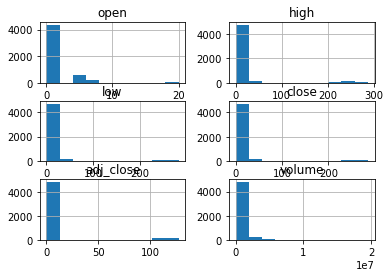

In [37]:
#TODO: Write your code here
stocks.toPandas().hist()

None of these histograms look like they have a normal distribution, as a matter of fact all of them look like threy're skewed to the right, which indidcates that the mode is the highest point in all these distributions. Let's take a look athe diffeent modes for each column.

In [38]:
stocks.describe().toPandas()

,summary,open,high,low,close,adj_close,volume,stock
0,count,5106,5106,5064,5106,5085,5085,5106
1,mean,1.0904873526012002,16.757624946793637,15.728619917198033,16.64199179044607,5.9866425135353065,540930.2458210423,None
2,stddev,2.3644535253049104,53.91407348193547,51.32292289814397,53.54677139900803,24.646370547153204,864596.2440525504,None
3,min,0.0,0.0,0.052377883,0.053624976,4.0381454E-7,0.0,AA
4,max,20.0,287.5,282.5,285.0,127.45936,1.95456E7,XOM


In [39]:
stocks.describe().toPandas()
modes = stocks['open','high','low','close','adj_close']
[modes.groupby(i).count().orderBy("count", ascending=False).first()[0] for i in modes.columns]

[0.0, 0.0, None, 29.5, None]

Above is a list of the modes of the all the columns. The low and the close have the same mode, thats very intersting. Also makes sense for the modes to be the highest values since the Distributions are right skewed, it look like HPQ (HP) os a very popular stock, appearing more than the 251 times all the other stocks seem to be appearing

In [48]:
print(stocks.approxQuantile('open', [0.5], 0.25)) #-- gives the medain of each column
print(stocks.approxQuantile('high', [0.5], 0.25))
print(stocks.approxQuantile('low', [0.5], 0.25))
print(stocks.approxQuantile('close', [0.5], 0.25))
print(stocks.approxQuantile('adj_close', [0.5], 0.25))
print(stocks.approxQuantile('volume', [0.5], 0.25))

[0.0]
[0.2473958283662796]
[0.2486979216337204]
[0.2578125]
[0.006715100724250078]
[42000.0]


> ℹ️ **Instructions** ℹ️
>
> Investigate the **open** column to identify stocks that have open values greater than 2, and note any anomalies that you find in the data.
>
>*You may use as many coding cells as necessary.*

In [40]:
#TODO: Write your code here
stocks.where(~F.col('open').between(0, 2)).show(5)

+----------+--------+---------+--------+---------+---------+--------+-----+
|      date|    open|     high|     low|    close|adj_close|  volume|stock|
+----------+--------+---------+--------+---------+---------+--------+-----+
|1962-02-19| 5.83929| 5.907375| 5.83929|  5.86332|1.3863293| 29900.0|   AA|
|1962-02-19|5.481634| 5.528486|5.481634|5.5167727|1.2804527| 32000.0| ARNC|
|1962-02-19|    7.26|7.2933335|7.173333|7.1866665|0.5825691|280000.0|  IBM|
|1962-02-14| 5.83929|  5.83929|5.747175|  5.80725|1.3730713| 56500.0|   AA|
|1962-02-14|5.481634| 5.481634|5.399644|5.4347825|1.2614225| 60400.0| ARNC|
+----------+--------+---------+--------+---------+---------+--------+-----+
only showing top 5 rows



In [41]:
stocks.createOrReplaceTempView('tbl')

spark.sql("""SELECT distinct(stock)
             FROM tbl
             WHERE open >2 """).show()

+-----+
|stock|
+-----+
|   AA|
|  IBM|
| ARNC|
|   PG|
|ARNCA|
+-----+



There are 753 instances where the open price is higher than 2 dollars, ant this is because of three stocks responsible for this are AA, ARNC and IBM

In [402]:
spark.sql("""SELECT count(stock) as AA
             FROM tbl
             WHERE open >2 and stock = 'AA'""").show()

+---+
| AA|
+---+
|252|
+---+



In [403]:
spark.sql("""SELECT count(stock) as IBM
             FROM tbl
             WHERE open >2 and stock = 'IBM'""").show()

+---+
|IBM|
+---+
|252|
+---+



In [404]:
spark.sql("""SELECT count(stock) as ARNC
             FROM tbl
             WHERE open >2 and stock = 'ARNC'""").show()

+----+
|ARNC|
+----+
| 231|
+----+



In [45]:
spark.sql("""SELECT *
             FROM tbl
             where  open <4 """).show(10)

+----------+-----------+-----------+----------+-----------+------------+---------+-----+
|      date|       open|       high|       low|      close|   adj_close|   volume|stock|
+----------+-----------+-----------+----------+-----------+------------+---------+-----+
|1962-02-19|  0.9074074| 0.91563785|0.89917696|  0.9032922|  0.16141544| 619400.0|   BA|
|1962-02-19|  1.6770834|  1.6927084| 1.6614584|  1.6770834|   0.1440587| 170400.0|  CAT|
|1962-02-19|        0.0|   3.578869|      20.0|   3.549107| 0.056501225| 273600.0|  CVX|
|1962-02-19|0.099767394|0.099767394|0.09820853| 0.09820853| 0.037543412| 817400.0|  DIS|
|1962-02-19|        0.0|    29.9375|     29.75|    29.9375|  0.49964145|   1600.0|  DTE|
|1962-02-19|        0.0|   9.921875|  9.890625|   9.921875|  0.22499175|   8800.0|   ED|
|1962-02-19|        0.0|  7.0833335| 7.0208335|  7.0208335|  0.91296524|  20400.0|   FL|
|1962-02-19| 0.77373797|   0.777494|0.76372194|   0.767478|0.0018262818|1557500.0|   GE|
|1962-02-19|        0

IBM is doing a very good job at skewing the data. Itopens up very high consistantly. It looks like for a normal distribution, we need to look at stocks with an opening between 0 - 4.



Looking at the open values that are higher than 2, we only see 3 rows in total. Looks they all opened above $6.00 but that IBM stock looks really off - definately an outlier that we could and should remove. AA and ARNC my also need to be removed as they may be skewing the results looking at the respective column means, meadians and modes these columns are nowhere near these values.

# ## 📔️**Notes** 📔️

 *Use this cell to note down any potential findings.*

 1. Looking at the summary statistics, we can see that the mean open value is around **1.09**, mean high is at **16.75**, mean low is **15.72**, mean close is at **16.64** adjusted close is **5.99** and the volume is **540930.25**
 
 2. The mode for the ope column is 0.0 and this alsommakes sense becaue most stoks open up at $0.00 
 3. None of these colunms look like they have a normal distribution oand the open column is no different. As a matter of fact, all of them look like threy're skewed to the right, which indidcates that the mode is the highest point in all these distributions.
 
4. Looking at the open values that are higher than 2, we aonly see 3 rows in total. Looks they all opened above $6.00 but that IBM stock looks really off - definately an outlier that we could and should remove. AA and ARNC my also need to be removed as they may be skewing the results looking at the respective column means, meadians and modes these columns are nowhere near these values.

> ℹ️ **Instructions** ℹ️
>
> Investigate **high**, **low**, **close**, and **adj_close** to determine if any stocks may be deviating from the normal ranges of the data set. Note down the stock(s) that you come across.
>
>*You may use as many coding cells as necessary.*

In [97]:
#TODO: Write your code here
stocks.describe(['high','low','close','adj_close']).toPandas()

,summary,high,low,close,adj_close
0,count,5106,5064,5106,5085
1,mean,16.757624946793637,15.728619917198033,16.64199179044607,5.9866425135353065
2,stddev,53.91407348193547,51.32292289814397,53.54677139900803,24.646370547153204
3,min,0.0,0.052377883,0.053624976,4.0381454E-7
4,max,287.5,282.5,285.0,127.45936


In [49]:
mean_high = 16.757624946793637
median_high = 0.2473958283662796
mode_high = 0

mean_low = 15.728619917198033
median_low = 0.2486979216337204
mode_low = 0

mean_close = 16.641991790446072
median_close = 0.2578125
mode_close = None

mean_adj_close = 5.9866425135353065
median_adj_close = 42000.0
mode_adj_close = 29.5


In [28]:
stocks.createOrReplaceTempView('explore')

spark.sql("""SELECT open,high,low,close,stock
            FROM explore
            WHERE high > 16.757624946793637""").show(5)

+----+-------+-------+-------+-----+
|open|   high|    low|  close|stock|
+----+-------+-------+-------+-----+
| 0.0|29.9375|  29.75|29.9375|  DTE|
| 0.0|  280.0|276.875|279.375|  NAV|
| 0.0|30.1875|29.6875| 29.875|  DTE|
| 0.0|276.875|273.125| 273.75|  NAV|
| 0.0|30.3125| 29.875|  30.25|  DTE|
+----+-------+-------+-------+-----+
only showing top 5 rows



In [50]:
stocks.where(~F.col('high').between(0.0,mean_high)).show()

+----------+----+-------+-------+-------+----------+------+-----+
|      date|open|   high|    low|  close| adj_close|volume|stock|
+----------+----+-------+-------+-------+----------+------+-----+
|1962-02-19| 0.0|29.9375|  29.75|29.9375|0.49964145|1600.0|  DTE|
|1962-02-19| 0.0|  280.0|276.875|279.375| 124.94374| 600.0|  NAV|
|1962-02-14| 0.0|30.1875|29.6875| 29.875| 0.4985984|2000.0|  DTE|
|1962-02-14| 0.0|276.875|273.125| 273.75| 122.42809| 800.0|  NAV|
|1962-02-13| 0.0|30.3125| 29.875|  30.25|0.50485736|8400.0|  DTE|
|1962-02-13| 0.0|  277.5|  275.0| 276.25| 123.54612|1000.0|  NAV|
|1962-02-26| 0.0|29.9375|  29.75|29.9375|0.49964145|2000.0|  DTE|
|1962-02-26| 0.0|279.375| 276.25|279.375| 124.94374| 700.0|  NAV|
|1962-02-06| 0.0|  28.75|28.5625| 28.625|0.47773674|4400.0|  DTE|
|1962-02-06| 0.0|271.875|268.125| 271.25| 121.31004|1600.0|  NAV|
|1962-02-02| 0.0|   28.5| 28.375|   28.5| 0.4756507|2200.0|  DTE|
|1962-02-02| 0.0| 266.25| 263.75| 266.25|119.073845| 800.0|  NAV|
|1962-02-1

In [56]:
spark.sql("""SELECT open,high,low,close,stock
            FROM explore
            WHERE low > 17.829749850183724 and close > 17.829749850183724""").show(2)

+----+-------+-------+-------+-----+
|open|   high|    low|  close|stock|
+----+-------+-------+-------+-----+
| 0.0|29.9375|  29.75|29.9375|  DTE|
| 0.0|  280.0|276.875|279.375|  NAV|
+----+-------+-------+-------+-----+
only showing top 2 rows



In [59]:
stocks.where(~F.col('low').between(0.0,mean_low)).show(10)

+----------+----+---------+-------+---------+-----------+--------+-----+
|      date|open|     high|    low|    close|  adj_close|  volume|stock|
+----------+----+---------+-------+---------+-----------+--------+-----+
|1962-02-19| 0.0| 3.578869|   20.0| 3.549107|0.056501225|273600.0|  CVX|
|1962-02-19| 0.0|  29.9375|  29.75|  29.9375| 0.49964145|  1600.0|  DTE|
|1962-02-19| 0.0|    280.0|276.875|  279.375|  124.94374|   600.0|  NAV|
|1962-02-14| 0.0|3.4970238|   20.0|3.4970238|0.055672023|116800.0|  CVX|
|1962-02-14| 0.0|  30.1875|29.6875|   29.875|  0.4985984|  2000.0|  DTE|
|1962-02-14| 0.0|  276.875|273.125|   273.75|  122.42809|   800.0|  NAV|
|1962-02-13| 0.0|3.5044644|   20.0|3.5044644|0.055790514|240000.0|  CVX|
|1962-02-13| 0.0|  30.3125| 29.875|    30.25| 0.50485736|  8400.0|  DTE|
|1962-02-13| 0.0|    277.5|  275.0|   276.25|  123.54612|  1000.0|  NAV|
|1962-02-26| 0.0|3.5193453|   20.0| 3.482143|0.055435114|158400.0|  CVX|
+----------+----+---------+-------+---------+------

In [25]:
spark.sql("""SELECT open,high,low,close,stock 
            FROM explore
            WHERE adj_close > 116.5""").show()

+----+-------+-------+-------+-----+
|open|   high|    low|  close|stock|
+----+-------+-------+-------+-----+
| 0.0|  280.0|276.875|279.375|  NAV|
| 0.0|276.875|273.125| 273.75|  NAV|
| 0.0|  277.5|  275.0| 276.25|  NAV|
| 0.0|279.375| 276.25|279.375|  NAV|
| 0.0|271.875|268.125| 271.25|  NAV|
| 0.0| 266.25| 263.75| 266.25|  NAV|
| 0.0|  277.5|274.375|  277.5|  NAV|
| 0.0|  280.0| 278.75|  280.0|  NAV|
| 0.0| 276.25|274.375| 276.25|  NAV|
| 0.0|  280.0|276.875|279.375|  NAV|
| 0.0|274.375|  272.5| 273.75|  NAV|
| 0.0|280.625| 278.75|  280.0|  NAV|
| 0.0|  267.5|265.625| 266.25|  NAV|
| 0.0|  275.0|271.875| 273.75|  NAV|
| 0.0|268.125|265.625| 266.25|  NAV|
| 0.0|  275.0|  272.5|274.375|  NAV|
| 0.0|274.375|  270.0|274.375|  NAV|
| 0.0|279.375| 276.25| 278.75|  NAV|
| 0.0| 281.25|276.875|276.875|  NAV|
| 0.0|273.125|270.625|273.125|  NAV|
+----+-------+-------+-------+-----+
only showing top 20 rows



In [71]:
spark.sql("""SELECT open,high,low,close,stock 
            FROM explore
            WHERE close > 16.64199179044607""").show(3)

+----+-------+-------+-------+-----+
|open|   high|    low|  close|stock|
+----+-------+-------+-------+-----+
| 0.0|29.9375|  29.75|29.9375|  DTE|
| 0.0|  280.0|276.875|279.375|  NAV|
| 0.0|30.1875|29.6875| 29.875|  DTE|
+----+-------+-------+-------+-----+
only showing top 3 rows



In [74]:
stocks.where(~F.col('close').between(0.053624976,mean_close)).show(3)

+----------+----+-------+-------+-------+----------+------+-----+
|      date|open|   high|    low|  close| adj_close|volume|stock|
+----------+----+-------+-------+-------+----------+------+-----+
|1962-02-19| 0.0|29.9375|  29.75|29.9375|0.49964145|1600.0|  DTE|
|1962-02-19| 0.0|  280.0|276.875|279.375| 124.94374| 600.0|  NAV|
|1962-02-14| 0.0|30.1875|29.6875| 29.875| 0.4985984|2000.0|  DTE|
+----------+----+-------+-------+-------+----------+------+-----+
only showing top 3 rows



In [78]:
spark.sql("""SELECT open,high,low,close,stock 
            FROM explore
            WHERE adj_close > 5.9866425135353065""").show(5)

+----+-------+-------+-------+-----+
|open|   high|    low|  close|stock|
+----+-------+-------+-------+-----+
| 0.0|  280.0|276.875|279.375|  NAV|
| 0.0|276.875|273.125| 273.75|  NAV|
| 0.0|  277.5|  275.0| 276.25|  NAV|
| 0.0|279.375| 276.25|279.375|  NAV|
| 0.0|271.875|268.125| 271.25|  NAV|
+----+-------+-------+-------+-----+
only showing top 5 rows



In [ ]:
stocks.where(~F.col('adj_close').between(0.000006,mode_adj_close)).show()

In [80]:
stocks.where(~F.col('adj_close').between(0.000006,mode_adj_close)).show(5)

+----------+----+----------+----------+----------+------------+---------+-----+
|      date|open|      high|       low|     close|   adj_close|   volume|stock|
+----------+----+----------+----------+----------+------------+---------+-----+
|1962-02-19| 0.0|0.23206018|0.23206018|0.23206018| 6.541049E-7|  43200.0|  JNJ|
|1962-02-19| 0.0|     280.0|   276.875|   279.375|   124.94374|    600.0|  NAV|
|1962-02-14| 0.0|0.24074075| 0.2337963| 0.2349537| 6.622604E-7|1080000.0|  JNJ|
|1962-02-14| 0.0|   276.875|   273.125|    273.75|   122.42809|    800.0|  NAV|
|1962-02-13| 0.0|0.24421297|0.24131945|0.24189815|6.8183493E-7| 734400.0|  JNJ|
+----------+----+----------+----------+----------+------------+---------+-----+
only showing top 5 rows



 ## 📔️**Notes** 📔️

 *Use this cell to note down any potential findings.*
 
 ### High

 1. The DTE and NAV stocks appear to be way outside of the normal bounds, these may be artificially inflated and colud skew the analysis later on. The NAV stock is looking very fishy here, with highs of over $200.00. DTEis playing around hthe high 20's and low 30's. maybe this is acceptable?
 2. The mode seems like a good measure for these reding,  since its causing the right skew, and from checking out the modes of all these stocks it looks like 
 
### Low

1. It appears the same two columns fall outside of the low parameters (min and mean)with the adddtion of the CVX stock

### Close 

1. Again here we have tyhe same the same stocks falling out of the normal ranges. DTE NAV

### Adj_close

1. It looks like only the NAV stock falls outside of the normal bounds here. this stack may definately need to be removed for a clearer picture of the stocks here. The JNJ stock also falls outside of the mode/mean parameters, this could also be one to watch



## Completeness

Completeness is the proportion of stored data against the potential of “100% complete". This is the degree to which the required data is in the dataset. 

Does the dataset have missing values, or if it is time-series data, does it have time period gaps? Has a bias been introduced that may change your assumptions or affect your results?

Completeness issues can occur at the row level (gaps within the dataset) or the field level (one entry missing). At the field level, entire fields can being empty, or >80% of a field's data missing. 

Another issue that may occur is default values. A typical example of this is where a logger sends back a 0 instead of a null value, which can greatly skew any attempts at modelling. This is where it is instrumental to employ domain knowledge when assessing a dataset. 

- **Measured by**: A measure of the absence of blank (null) values or the presence of non-blank values;
- **Units**: Percentage;
- **Related to**: Validity and Accuracy.

### Missing values

> ℹ️ **Instructions** ℹ️
>
> Write code to identify and count the number of missing values (nulls) in the dataset. Include a percentage to describe the proportion of missing values per column. Output the results in the following manner:
>
> `There are <number_of_missing_values> (<percentage>) null values in <column_name> column`
>
>*You may use as many coding cells as necessary.*

In [86]:
#TODO: Write your code here
missing_count = {}  # Dictionary to keep track of the results
for column in stocks.columns:   # loop through each column
    _count = stocks.where(stocks[column].isNull()).count()  # null count in column x
    _total_count = stocks.select(stocks[column]).count()    # total count of column x 
    print(f'There are {_count} ({round(_count/_total_count*100, 3)}%) null values in {column} column')  # print out and calculate results
    missing_count[f'{column}'] = _count # recording results in missing_count dictionary 

There are 0 (0.0%) null values in date column
There are 0 (0.0%) null values in open column
There are 0 (0.0%) null values in high column
There are 42 (0.823%) null values in low column
There are 0 (0.0%) null values in close column
There are 21 (0.411%) null values in adj_close column
There are 21 (0.411%) null values in volume column
There are 0 (0.0%) null values in stock column


### Columns with missing values


> ℹ️ **Instructions** ℹ️
>
> From the above result, probe the columns that are affected by the missing data to find out which stocks were affected.
>
>*You may use as many coding cells as necessary.*

In [112]:
#TODO: Write your code here
stocks.filter("low is NULL").show(50)

+----------+---------+---------+----+---------+----------+--------+-----+
|      date|     open|     high| low|    close| adj_close|  volume|stock|
+----------+---------+---------+----+---------+----------+--------+-----+
|1962-12-03|      0.0|    247.5|null|    247.5|  114.7004|   500.0|  NAV|
|1962-12-20|      0.0|   241.25|null|  239.375|112.296135|   600.0|  NAV|
|1962-12-21|      0.0|  243.125|null|    242.5| 113.76213|   500.0|  NAV|
|1962-03-20|1.6666666|1.6979166|null|1.6979166|0.14584826|177600.0|  CAT|
|1962-03-14|1.6302084|1.6614584|null|1.6614584|0.14271663|117600.0|  CAT|
|1962-12-31|      0.0|  250.625|null|   248.75| 116.69414|   600.0|  NAV|
|1962-12-28|      0.0|  249.375|null|  248.125| 116.40094|   300.0|  NAV|
|1962-03-22|1.6666666|1.6927084|null|1.6822916|0.14450607|268800.0|  CAT|
|1962-12-18|      0.0|   238.75|null|   236.25|  110.8301|   900.0|  NAV|
|1962-03-19|1.6614584|1.6822916|null|1.6614584|0.14271663|105600.0|  CAT|
|1962-12-19|      0.0|    240.0|null| 

From the above it looks like it's only the NAV (Navient) and CAT (Caterpillar) stocks that have missing data. What's a little strange here is the for the NAV stock all the null low values occur when the open value is zero. The CAT stocks missing low data looks random,maybe it would be best to remove this data.

#### Fix Completeness

How do we deal with incomplete data?
- Dropping missing values
- Discard the incomplete column
- Discard the rows containing missing data
- Case deletion

> ℹ️ **Instructions** ℹ️
>
> Use the appropriate strategy to remedy the missing data. 
>
>*You may use as many coding cells as necessary.*

In [115]:
#TODO: Write your code here

stocks_clean_low = stocks.na.drop(subset=["low"])

In [118]:
stocks_clean_low.filter("low is NULL").show(50)

+----+----+----+---+-----+---------+------+-----+
|date|open|high|low|close|adj_close|volume|stock|
+----+----+----+---+-----+---------+------+-----+
+----+----+----+---+-----+---------+------+-----+



Looks good. The dataframe no longer has missing data for the entire low column and we can move on now.

### Zero Values

Take a deeper look into the entries with many zero values.

#### Fix Completeness

Completeness issues can be fixed through imputation of the missing data through:
- imputation by mean/mode/median;
- regression; or
- KNN.
 
> ℹ️ **Instructions** ℹ️
>
> Write code to identify and count the number of zeros (0) in the dataset. Include a percentage to describe the proportion of missing values per column. Output the results in the following manner:
>
> `There are <number_of_zeros> (<percentage>) zero values in <column_name> column`
>
>*You may use as many coding cells as necessary.*

In [214]:
#TODO: Write your code here
st = stocks_clean_low['open','high','low','close','adj_close','volume']

In [217]:
zero_count = {}  # Dictionary to keep track of the results
for column in st.columns:   # loop through each column
    _count = st.filter(stocks_clean_low[column] == 0).count()  # null count in column x
    _total_count = st.select(stocks[column]).count()    # total count of column x 
    print(f'There are {_count} ({round(_count/_total_count*100, 3)}%) zero values in {column} column')  # print out and calculate results
    zero_count[f'{column}'] = _count # recording results in missing_count dictionary 

There are 2748 (54.265%) zero values in open column
There are 20 (0.395%) zero values in high column
There are 0 (0.0%) zero values in low column
There are 0 (0.0%) zero values in close column
There are 0 (0.0%) zero values in adj_close column
There are 27 (0.533%) zero values in volume column


From the above section, you find that there are a few columns that contain zero values. However, some of these are true zeros and are explainable. Your task is to distinguish which column should undergo data imputation.

> ℹ️ **Instructions** ℹ️
>
> Investigate the columns with zero values and determine which one should undergo data imputation. Take note of the stock and month on which zero values occurred.
>
>*You may use as many coding cells as necessary.*

So I realise that I need to think about this very carefully. Looking at the open column, It could be fair to think that this coulmn doesn't reeally require any data impuation, so for now I'll leave it as is. The High column However should (instinctively) have some sort of value in in especially of there was volume traded for a prticular stock. The same should be true for the volums column, if a stock has an opening and a closing value, it should have volume traded right? Right, now let's look into this carefully 

In [237]:
#TODO: Write your code here
stocks_clean_low.createOrReplaceTempView('st')
spark.sql("""SELECT * 
        FROM st
        WHERE high = 0
        """).show(2)

+----------+---------+----+---------+---------+----------+--------+-----+
|      date|     open|high|      low|    close| adj_close|  volume|stock|
+----------+---------+----+---------+---------+----------+--------+-----+
|1962-11-05|1.4114584| 0.0|1.4114584|   1.4375|0.12620474|172800.0|  CAT|
|1962-11-12| 1.453125| 0.0|1.4427084|1.4583334|0.12803373| 96000.0|  CAT|
+----------+---------+----+---------+---------+----------+--------+-----+
only showing top 2 rows



In [375]:
spark.sql("""SELECT * 
        FROM st
        WHERE volume = 0
        """).show(100)

+----------+----------+----------+----------+----------+------------+------+-----+
|      date|      open|      high|       low|     close|   adj_close|volume|stock|
+----------+----------+----------+----------+----------+------------+------+-----+
|1962-05-18|       0.0| 1.6679688| 1.6484375| 1.6679688| 0.015032374|   0.0|  XOM|
|1962-05-24|       0.0| 1.6328125| 1.6171875| 1.6289062|  0.01468032|   0.0|  XOM|
|1962-09-28|       0.0|0.15914352| 0.1574074|0.15914352| 4.514184E-7|   0.0|  JNJ|
|1962-05-08|       0.0| 1.7265625| 1.7109375| 1.7148438| 0.015285846|   0.0|  XOM|
|1962-01-02|       0.0|0.22337963|0.22222222|0.22337963| 6.281419E-7|   0.0|  JNJ|
|1962-05-14|       0.0|  1.640625| 1.5820312| 1.6328125| 0.014715531|   0.0|  XOM|
|1962-05-28|       0.0|    1.5625| 1.4179688|    1.4375| 0.012955305|   0.0|  XOM|
|1962-05-25|       0.0| 1.6328125|  1.578125|   1.59375|  0.01436349|   0.0|  XOM|
|1962-05-29|       0.0|   1.59375| 1.4179688| 1.5898438| 0.014328282|   0.0|  XOM|
|196

Looks like the only culprit here is the CAT stock and it's reaponsible for all 20 missing high values. looking at it a little more closely though, this shouldn't be the case for instances where the closing value is higher than the open value.  according to the below instructios this is the cloumn that will have to be given the average value of the stock.

The XOM and JNJ stocks have missing values in the volume column, which to me dosen't make sence since there was tradeing for these stocks on the days the volume was zero. The GE stock also has missing volume data for 1962-11-09, but this looks legit-ish, so I'll leave it as is. 

> ℹ️ **Instructions** ℹ️
>
> Once you have identified the column that needs to undergo imputation, update the values for the affected records by using the average value for the affected stock.
>
>*You may use as many coding cells as necessary.*

In [277]:
cat_window = Window.partitionBy(F.col('stock'))

df_months_imputed = df_months.withColumn('high', F.when(F.col('high') =0, F.mean('high').over(cat_window)).otherwise(F.col('high')))


In [287]:
df_months_imputed.createOrReplaceTempView('see2')
spark.sql("""select * from see2 where high = 0""").show()

+----+----+----+---+-----+---------+------+-----+-----+
|date|open|high|low|close|adj_close|volume|stock|month|
+----+----+----+---+-----+---------+------+-----+-----+
+----+----+----+---+-----+---------+------+-----+-----+



In [282]:
df_months_imputed2 = df_months_imputed

In [288]:
df_months_imputed2 = df_months_imputed.withColumn('volume', F.when(F.col('volume') ==0, F.mean('volume').over(cat_window)).otherwise(F.col('volume')))
df_months_imputed2.createOrReplaceTempView('see3')
spark.sql("""select * from see3 where volume= 0""").show()

+----+----+----+---+-----+---------+------+-----+-----+
|date|open|high|low|close|adj_close|volume|stock|month|
+----+----+----+---+-----+---------+------+-----+-----+
+----+----+----+---+-----+---------+------+-----+-----+



Looks legit. I can say with certanty that the data has been successfully imputed


## Consistency

Consistency is the absence of difference when comparing two or more representations of a thing against a reference.

Data entries that refer to the same record or entity have to be consistent across all entries, e.g., if you are dealing with records from a logger in the field, the entries for that logger have to remain consistent, and the name or primary key of that logger cannot change from one entry to another. 

For example, 'Logger1', 'Loger1' and 'Logge1' are examples of inconsistent keys. 

This is not just within a single table but also becomes more important if you are dealing with relational data. In which case, the mappings between tables and systems must be consistent. If not, the relationships will be completely lost between the tables and referential integrity compromised. 

- **Measured by**: Analysis of pattern and/or value frequency;
- **Units**: Percentage;
- **Related to**: Accuracy, Validity, and Uniqueness.

> ℹ️ **Instructions** ℹ️
>
> There currently exists a stock that has inconsistent naming. Make use of the metadata to determine which stock is inconsistently named, then update the dataframe appropriately to get rid of this inconsistency.
>
>*You may use as many coding cells as necessary.*

In [330]:
# metadata.select(F.col("symbol")).show(5000)
symbol_list = list(metadata.select('symbol').toPandas()['symbol'])


In [329]:
#TODO: Write your code here
# df_months_imputed2.select(F.col("stock")).orderBy(F.col("stock")).show(5000)
stock_list = list(df_months_imputed2.select('stock').toPandas()['stock'])
stock_list = list(dict.fromkeys(stock_list))

In [331]:
for stock in stock_list:
        
    if stock in symbol_list:
        continue 
    else:
        print("stock "+ stock+" isn't in the metadata list")

stock ARNCA isn't in the metadata list


In [336]:
consistant_df = df_months_imputed2.withColumn("stock", F.when(df_months_imputed2.stock == "ARNCA","ARNC") \
      .otherwise(df_months_imputed2.stock))

## Timeliness

Timeliness is the degree to which data represent reality from the required point in time.

Timeliness expects that the data within your dataset is sufficiently up to date. If you are trying to answer questions that relate to recent problems, having timely data is extremely important. For example, you cannot use current flight patterns to model how many aeroplanes will be required by a large aeronautics company within the next 5-10 years. 

Similarly, when answering questions that require real-time answers (e.g., predicting when a pipe will burst in a manufacturing plant), you have to be set up to receive real-time data from sensors and loggers. 

- **Measured by**: Time difference;
- **Units**: Time;
- **Related to**: Accuracy because it will decay as time progress. 

It is important to see the latest value for each of the stocks that we are looking at:

In [337]:
consistant_df.groupBy('stock').agg(F.max('Date')).show()

+-----+----------+
|stock| max(Date)|
+-----+----------+
|   AA|1962-12-31|
|   BA|1962-12-31|
|   ED|1962-12-31|
|   FL|1962-12-31|
|  IBM|1962-12-31|
|   GE|1962-12-31|
| ARNC|1962-12-31|
|  CVX|1962-12-31|
|  NAV|1962-11-30|
|   PG|1962-12-31|
|  DIS|1962-12-31|
|  HPQ|1962-12-31|
|   IP|1962-12-31|
|   KO|1962-12-31|
|   MO|1962-12-31|
|  XOM|1962-12-31|
|  CAT|1962-12-31|
|  DTE|1962-12-31|
|   GT|1962-12-31|
|  JNJ|1962-12-31|
+-----+----------+



Sometimes, some of these axes of data quality will be less important than others. 
This is one of those cases where it is less important to have timely data, since 
we are trying to create a training dataset for a stock market prediction algorithm. 

It is important to know the context in which you are doing your modelling. 

### Gaps in the dataset

Let's see if we can find inconsistencies in the time series by having a look at the number of entries for each of the tickers.
 
> ℹ️ **Instructions** ℹ️
>
> Uncomment and use the below code to determine which dates had entries that were not equal to 20. You may have to change the name of the dataframe to see the resultant output
>
>*You may use as many coding cells as necessary.*

In [338]:
consistant_df.orderBy('date').groupby('date').count().where(F.col('count') != 20).show(400)

+----------+-----+
|      date|count|
+----------+-----+
|1962-02-19|   23|
|1962-02-05|   23|
|1962-02-01|   23|
|1962-02-07|   23|
|1962-09-25|   21|
|1962-09-24|   21|
|1962-03-22|   19|
|1962-02-27|   23|
|1962-09-12|   21|
|1962-09-10|   21|
|1962-09-13|   21|
|1962-12-03|   19|
|1962-02-06|   23|
|1962-02-02|   23|
|1962-02-12|   23|
|1962-02-09|   23|
|1962-02-15|   23|
|1962-09-26|   21|
|1962-09-04|   21|
|1962-09-17|   21|
|1962-09-21|   21|
|1962-09-28|   21|
|1962-03-20|   19|
|1962-12-31|   19|
|1962-12-28|   19|
|1962-03-19|   19|
|1962-02-14|   23|
|1962-02-28|   23|
|1962-02-23|   23|
|1962-09-07|   21|
|1962-09-11|   21|
|1962-09-05|   21|
|1962-09-14|   21|
|1962-09-27|   21|
|1962-12-21|   19|
|1962-03-14|   19|
|1962-12-18|   19|
|1962-02-13|   23|
|1962-02-26|   23|
|1962-02-16|   23|
|1962-02-20|   23|
|1962-02-08|   23|
|1962-02-21|   23|
|1962-09-18|   21|
|1962-09-20|   21|
|1962-09-06|   21|
|1962-09-19|   21|
|1962-12-20|   19|
|1962-12-26|   19|
|1962-12-19|

> ℹ️ **Instructions** ℹ️
>
> From the above result, investigate the number of times a stock appears for the given month. You can infer the months by using the output of the previous cell.
>
>*You may use as many coding cells as necessary.*

In [347]:
#TODO: Write your code here
consistant_df.show(2)
# consistant_df.groupby(['month'])['stock'].value_counts().unstack().fillna(0).astype(int).reindex()

+----------+-------+-----------------+--------+-------+---------+-------+-----+-----+
|      date|   open|             high|     low|  close|adj_close| volume|stock|month|
+----------+-------+-----------------+--------+-------+---------+-------+-----+-----+
|1962-02-19|5.83929|5.907374858856201| 5.83929|5.86332|1.3863293|29900.0|   AA|    2|
|1962-02-14|5.83929|5.839290142059326|5.747175|5.80725|1.3730713|56500.0|   AA|    2|
+----------+-------+-----------------+--------+-------+---------+-------+-----+-----+
only showing top 2 rows



In [353]:
consistant_df.groupBy("month","stock").count().orderBy('month').show(3)

+-----+-----+-----+
|month|stock|count|
+-----+-----+-----+
|    1|   MO|   22|
|    1| ARNC|   22|
|    1|   BA|   22|
+-----+-----+-----+
only showing top 3 rows



## Uniqueness

Uniqueness requires that nothing will be recorded more than once based upon how that thing is identified. It is the inverse of an assessment of the level of duplication.

Each entry within the dataset should only relate to a single event that has occurred and thus should not be duplicated. This is largely mediated by having the appropriate primary key, which means sticking to the requirements of a good primary key. All fields in the tables should be non-transitively dependent on the primary key.

As such, deduplication of the dataset may be required. 

- **Measured by**: Analysis of the number of things assessed in the “real world” compared to the number of records of things in the dataset. This requires a reference dataset which is the ground truth;
- **Units**: Percentage;
- **Related to**: Consistency.

### Duplication Test
For time-series data, it is important to check for duplications, as we typically expect all values to be unique within the dataset.

The first thing to check will be if the primary key values within the dataset are unique - in our case, that will be a combination of the stock name and the date.

Secondly, we want to check if the entries are all unique, which is done by checking for duplicates across that whole dataset.

> ℹ️ **Instructions** ℹ️
>
> Write code to determine if there are any duplicates within the data, and then proceed to correct this by dropping them from the dataframe.
>
>*You may use as many coding cells as necessary.*

In [405]:
#TODO: Write your code here

consistant_df.groupby(['date', 'stock']) \
  .count() \
  .where('count > 1') \
  .sort('count', ascending=False) \
  .show(200)

+----------+-----+-----+
|      date|stock|count|
+----------+-----+-----+
|1962-02-06|  HPQ|    4|
|1962-02-13|  HPQ|    4|
|1962-02-02|  HPQ|    4|
|1962-02-15|  HPQ|    4|
|1962-02-27|  HPQ|    4|
|1962-02-16|  HPQ|    4|
|1962-02-26|  HPQ|    4|
|1962-02-09|  HPQ|    4|
|1962-02-12|  HPQ|    4|
|1962-02-07|  HPQ|    4|
|1962-02-21|  HPQ|    4|
|1962-02-20|  HPQ|    4|
|1962-02-19|  HPQ|    4|
|1962-02-01|  HPQ|    4|
|1962-02-28|  HPQ|    4|
|1962-02-23|  HPQ|    4|
|1962-02-14|  HPQ|    4|
|1962-02-08|  HPQ|    4|
|1962-02-05|  HPQ|    4|
|1962-09-13|   ED|    2|
|1962-09-06|   ED|    2|
|1962-09-14|   ED|    2|
|1962-09-18|   ED|    2|
|1962-09-26|   ED|    2|
|1962-09-21|   ED|    2|
|1962-09-25|   ED|    2|
|1962-09-20|   ED|    2|
|1962-09-17|   ED|    2|
|1962-09-04|   ED|    2|
|1962-09-28|   ED|    2|
|1962-09-07|   ED|    2|
|1962-09-24|   ED|    2|
|1962-09-19|   ED|    2|
|1962-09-12|   ED|    2|
|1962-09-10|   ED|    2|
|1962-09-27|   ED|    2|
|1962-09-05|   ED|    2|


Looking at duplicates, it seems we have quite high number of dulicates for the HP stock(HPQ)and the ED stock on various dates, this will most certsinly need to be rectified

In [357]:
no_duplicates = consistant_df.dropDuplicates(['date', 'stock'])

In [358]:
no_duplicates.show(3)

+----------+-------+------------------+--------+--------+---------+-------+-----+-----+
|      date|   open|              high|     low|   close|adj_close| volume|stock|month|
+----------+-------+------------------+--------+--------+---------+-------+-----+-----+
|1962-02-14|5.83929| 5.839290142059326|5.747175| 5.80725|1.3730713|56500.0|   AA|    2|
|1962-02-13|5.85531| 5.915384769439697| 5.85531| 5.86332|1.3863293|62500.0|   AA|    2|
|1962-02-26|6.05556|6.1076250076293945|5.955435|6.107625|1.4440926|82500.0|   AA|    2|
+----------+-------+------------------+--------+--------+---------+-------+-----+-----+
only showing top 3 rows



In [385]:
no_duplicates.groupby(['date', 'stock']) \
  .count() \
  .where('count > 1') \
  .sort('count', ascending=False) \
  .show(2)

+----+-----+-----+
|date|stock|count|
+----+-----+-----+
+----+-----+-----+



## Validity
Data is valid if it conforms to the syntax (format, type, range) of its definition.

Certain values within a field may have specific criteria required to make it valid, e.g., numerical columns cannot contain alphabetical characters, which can occur due to scientific notation.

This can be more difficult to determine in stings, in which case you may have to check using regex. 

- **Measured by**: Comparison between the data and metadata or documentation for the data item;
- **Units**: Percentage of data items deemed Valid or Invalid;
- **Related to**: Accuracy, Completeness, Consistency, and Uniqueness.

We need to first define what we expect from our dataset:

- stock: string (nullable = true) => Should be contained in the list of expected tickers
- date: date (nullable = true) => Should conform to date format, and be in the past
- open: double (nullable = true) => Should be positive or 0
- high: double (nullable = true) => Should be positive or 0
- low: double (nullable = true) => Should be positive or 0 (should be < high)
- close: double (nullable = true) => Should be positive or 0 (should be <= high )
- adj_close: double (nullable = true) => Should be positive or 0
- volume: integer (nullable = true) => Should be positive or 0
- high_avg: double (nullable = true) => Derived (not needed to test)
- high_imp: double (nullable = true) => Derived (not needed to test)
- day_of_week: string (nullable = true) => Derived (not needed to test)

*Is there any other logic that we can incorporate?*

> ℹ️ **Instructions** ℹ️
>
> Use the metadata to check if all the stocks in your current dataframe are valid. In other words, make sure you have no foreign/unknown tickers in your dataframe.
>
>*You may use as many coding cells as necessary.*


In [361]:
#TODO: Write your code here
stock_list = list(no_duplicates.select('stock').toPandas()['stock'])
stock_list = list(dict.fromkeys(stock_list))

for stock in stock_list:  
    if stock in symbol_list:
        print("stock "+ stock+" is in the metadata list") 
    else:
        print("stock "+ stock+" isn't in the metadata list")

stock AA is in the metadata list
stock IBM is in the metadata list
stock JNJ is in the metadata list
stock KO is in the metadata list
stock PG is in the metadata list
stock ARNC is in the metadata list
stock FL is in the metadata list
stock IP is in the metadata list
stock CAT is in the metadata list
stock CVX is in the metadata list
stock HPQ is in the metadata list
stock XOM is in the metadata list
stock BA is in the metadata list
stock DTE is in the metadata list
stock GT is in the metadata list
stock GE is in the metadata list
stock DIS is in the metadata list
stock NAV is in the metadata list
stock ED is in the metadata list
stock MO is in the metadata list


Looks like all the tickers in the dataframe are correct - we can proceed.

> ℹ️ **Instructions** ℹ️
>
>
>Check if the date column contains only valid dates and all dates are in the past.
>
>*Valid dates should already be checked in the data reading step.*

In [369]:
#TODO: Write your code here
no_duplicates_year = no_duplicates.withColumn("year", F.year('date'))
no_duplicates_year.createOrReplaceTempView('inspect')

spark.sql("""SELECT * FROM inspect where year != 1962""").show()

+----+----+----+---+-----+---------+------+-----+-----+----+
|date|open|high|low|close|adj_close|volume|stock|month|year|
+----+----+----+---+-----+---------+------+-----+-----+----+
+----+----+----+---+-----+---------+------+-----+-----+----+



Looks like the years are all consistant, none in the past and none in the future.

> ℹ️ **Instructions** ℹ️
>
>Check that all of numerical columns are positive.

In [373]:
#TODO: Write your code here
spark.sql("""SELECT * FROM inspect where open < 0""").show()
spark.sql("""SELECT * FROM inspect where high < 0 """).show()
spark.sql("""SELECT * FROM inspect where low < 0""").show()
spark.sql("""SELECT * FROM inspect where close < 0""").show()
spark.sql("""SELECT * FROM inspect where adj_close < 0""").show()
spark.sql("""SELECT * FROM inspect where volume < 0""").show()
spark.sql("""SELECT * FROM inspect where stock < 0""").show()

+----+----+----+---+-----+---------+------+-----+-----+----+
|date|open|high|low|close|adj_close|volume|stock|month|year|
+----+----+----+---+-----+---------+------+-----+-----+----+
+----+----+----+---+-----+---------+------+-----+-----+----+

+----+----+----+---+-----+---------+------+-----+-----+----+
|date|open|high|low|close|adj_close|volume|stock|month|year|
+----+----+----+---+-----+---------+------+-----+-----+----+
+----+----+----+---+-----+---------+------+-----+-----+----+

+----+----+----+---+-----+---------+------+-----+-----+----+
|date|open|high|low|close|adj_close|volume|stock|month|year|
+----+----+----+---+-----+---------+------+-----+-----+----+
+----+----+----+---+-----+---------+------+-----+-----+----+

+----+----+----+---+-----+---------+------+-----+-----+----+
|date|open|high|low|close|adj_close|volume|stock|month|year|
+----+----+----+---+-----+---------+------+-----+-----+----+
+----+----+----+---+-----+---------+------+-----+-----+----+

+----+----+----+---+

Looks like there are no numeric values lower than zero

In [406]:
spark.sql("""SELECT * FROM inspect where month = 03""").show(1)

+----------+------+-----------------+------+------+---------+-------+-----+-----+----+
|      date|  open|             high|   low| close|adj_close| volume|stock|month|year|
+----------+------+-----------------+------+------+---------+-------+-----+-----+----+
|1962-03-15|6.6483|6.724394798278809|6.6483|6.6483|1.5719309|41900.0|   AA|    3|1962|
+----------+------+-----------------+------+------+---------+-------+-----+-----+----+
only showing top 1 row



### Save Updates

With our initial work of checking the various dimensions of the data quality completed, we can now save these results to a CSV file.  

In [407]:
pd_df = no_duplicates_year.toPandas()

In [408]:
pd_df.to_csv('/Users/daluxolombatha/Desktop/Daluxolo_Mbatha_data_profiling.csv')